# setup

In [1]:
import os
import locate_file

working_directory = locate_file.locate_file()
os.chdir(working_directory)

import setup
import matplotlib
%matplotlib inline

platform : darwin


# image_processing.c

In [2]:
%%file image_processing.c

void convolution(int *image,int *return_image,int *kernel,int image_width, int image_height, int kernel_size, int kernel_normalizer) {
    
    int border_width = (kernel_size-1)/2;
    int image_starting_x = 0;
    int image_starting_y = 0;
    int image_ending_x = image_width - kernel_size + 1;
    int image_ending_y = image_height - kernel_size + 1;
    
    int i,j,u,v;
    int sum;

    for(i=image_starting_y;i<image_ending_y;i++) {
        for(j=image_starting_x;j<image_ending_x;j++) {
            
            //current left top corner pixel is i,j
            sum = 0;
            for(u=0;u<kernel_size;u++) {
                for(v=0;v<kernel_size;v++) {
                    sum += (*(image + image_width*(i+u) + j+v))*(*(kernel + u*kernel_size + v));
                }
            }
            *(return_image + (image_width*(i+border_width)) + j+border_width) = (sum/kernel_normalizer);
        }
    }
}

// void sobel_operator(int *image,int *grad_x,int *grad_y,int image_width,int image_height) {

//     int kernel_x[3][3] = {{1,0,-1},{2,0,-2},{1,0,-1}};
//     int kernel_y[3][3] = {{1,2,1},{0,0,0},{-1,-1,-1}};

//     for 

// }

Overwriting image_processing.c


In [3]:
setup.compile()

compiling image_processing.c


In [4]:
%%file libconvolution.py
import ctypes
import numpy
import setup

_image_processing_ = ctypes.cdll.LoadLibrary(setup.shared_object_library_name)

#Python class for defining 2dimensional array type as required by Ctypes library
class two_d_array() : 
    
    def from_param(self,param) : 
        typename = type(param).__name__
        if hasattr(self,'from_'+typename) : 
            return getattr(self,'from_'+typename)(param)
        elif isinstance(param,ctypes.Array) : 
            
            return param
        else : 
            raise TypeError('type {0} not supported'.format(typename))
    
    def from_ndarray(self,param) : 
        c_array = numpy.ascontiguousarray(param,dtype=numpy.int32)
        pointer = c_array.ctypes
        return pointer
    
    def from_list(self,param) : 
        return self.from_ndarray(param)
    
    def from_tuple(self,param) : 
        return self.from_ndarray(param)
    
two_d_array_ = two_d_array()

#defining argtypes and restypes for _image_processing_.convolution function
_image_processing_.convolution.argtypes = [two_d_array_,two_d_array_,\
two_d_array_,ctypes.c_int,ctypes.c_int,ctypes.c_int,ctypes.c_int]
_image_processing_.convolution.restype = ctypes.c_void_p

def convolution(image,kernel,convert_to_uint8=True) :

    image_height = len(image)
    image_width = len(image[0])
    kernel_normalizer = kernel[0]
    kernel = kernel[1] 
    
    #generate a new ctypes array and convert it into a numpy array
    return_c_array = numpy.ctypeslib.as_array(((ctypes.c_int*image_width)*image_height)())
    #generate a contiguous aray in memory for the image and the kernel
    image_c_array = numpy.ascontiguousarray(image,dtype=numpy.int32)
    kernel_c_array = numpy.ascontiguousarray(kernel,dtype=numpy.int32)
    
    #calling the _image_processing_.convolution function and passing appropriate parameters
    _image_processing_.convolution(image_c_array,return_c_array,kernel_c_array,\
        len(image[0]),len(image),len(kernel),kernel_normalizer)

    if convert_to_uint8 : 
        return numpy.ascontiguousarray(return_c_array,dtype=numpy.uint8)
    else :
        return numpy.ascontiguousarray(return_c_array,dtype=numpy.int32)


Overwriting libconvolution.py


# ctypes classes
* ctypes.c_int is a built in class defined in the ctypes module, that generates ctypes.c_int objects
* ctypes.c_int*n can be used to generate an 1 dimensional array class, with elements as integers
* this ctype array class can be used to generate ctypes array objects
* finally, any ctypes array object can be converted to a numpy array using numpy.ctypeslib.as_array function

In [5]:
import ctypes
import numpy

#generating a new ctypes.c_int object with value 10
print('ctypes.c_int class --> ',ctypes.c_int(10))

#generating a nw ctypes.c_int array class
array = ctypes.c_int*10
print('ctypes array class --> ',array)

#generating objects that are instances of ctypes.c_int array class
m = array()
print('ctypes array object --> ',m)

# now this array can be used as a parameter to be passed to a C function, and can be converted to a numpy ndarray
nparray = numpy.ctypeslib.as_array(m)
print('numpy array --> ',nparray)

#now this numpy array can be used as any other numpy array

#similarly, N dimensional arrays can be generated using this approach
two_d_array = (ctypes.c_int*10)*10
m = two_d_array()
two_d_nparray = numpy.ctypeslib.as_array(m)
print('two dimensional numpy array --> \n' ,two_d_nparray)

#the numpy array generated shares the underlying memory with the ctypes object, and hence the conversion is very fast

ctypes.c_int class -->  c_int(10)
ctypes array class -->  <class '__main__.c_int_Array_10'>
ctypes array object -->  <__main__.c_int_Array_10 object at 0x1055ff730>
numpy array -->  [0 0 0 0 0 0 0 0 0 0]
two dimensional numpy array --> 
 [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


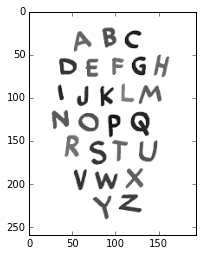

In [6]:
from image_handling import read_image,display_image
image = read_image('sample_images/sample_image_1.png')
display_image(image)

255


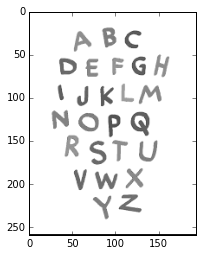

In [7]:
import libconvolution
from gaussian import gaussian
g = gaussian()
kernel = g.generate_gaussian_smoothening_kernel(0.1)
image = libconvolution.convolution(image,kernel,convert_to_uint8 = False)
display_image(image)

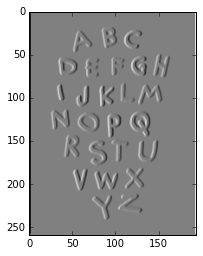

In [8]:
import libconvolution

kernel_x = [1,[[1,0,-1],[2,0,-2],[1,0,-1]]]
convolved_image_x = libconvolution.convolution(image,kernel_x,convert_to_uint8 = False)
display_image(convolved_image_x)

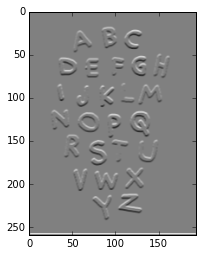

In [9]:
kernel_y = [1,[[1,2,1],[0,0,0],[-1,-2,-1]]]
convolved_image_y = libconvolution.convolution(image,kernel_y,convert_to_uint8 = False)
display_image(convolved_image_y)

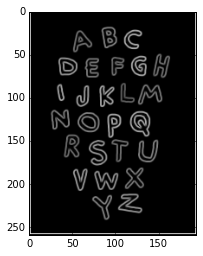

In [10]:
import math
magnitude = []
for i in range(len(convolved_image_x)) :
    magnitude.append([])
    for j in range(len(convolved_image_x[0])) : 
        magnitude[-1].append(math.sqrt((convolved_image_x[i][j]**2) + (convolved_image_y[i][j]**2)))
        
display_image(magnitude)